# Laboratorium 5 - rekomendacje grupowe

## Przygotowanie

 * pobierz i wypakuj dataset: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
   * więcej możesz poczytać tutaj: https://grouplens.org/datasets/movielens/
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab5`
 * zainstaluj potrzebne biblioteki:
 `pip install numpy pandas matplotlib`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse.linalg import svds
from collections import defaultdict

from random import choice, sample, random
from statistics import mean, stdev

from reco_utils import *

In [2]:
# wczytujemy oceny uzytkownikow i obliczamy (za pomocą dekompozycji macierzy) wszystkie przewidywane oceny filmow
PATH = "ml-latest-small/ratings.csv"
def read_ratings(path, k=600, scale_factor=2.0, print_stats=True):
    # idea: https://www.kaggle.com/code/indralin/movielens-project-1-2-collaborative-filtering
    reviews = pd.read_csv('ml-latest-small/ratings.csv', names=['userId', 'movieId', 'rating', 'time'], delimiter=',', engine='python', skiprows=1)
    
    reviews.drop(['time'], axis=1, inplace=True)
    reviews_no, _ = reviews.shape
    reviews_matrix = reviews.pivot(index='userId', columns='movieId', values='rating')
    movies = reviews_matrix.columns
    users = reviews_matrix.index
    users_no, movies_no = reviews_matrix.shape
    print(f'Got {reviews_no} reviews for {movies_no} movies and {users_no} users.')

    user_ratings_mean = np.nanmean(reviews_matrix.values, axis=1)
    normalized_reviews_matrix = np.nan_to_num(reviews_matrix.values - user_ratings_mean.reshape(-1, 1), 0.0)

    U, sigma, Vt = svds(normalized_reviews_matrix, k=k)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1).clip(0.5, 5.0)
    mean_square_error = np.nanmean(np.square(predicted_ratings - reviews_matrix.values))
    std_square_error = np.nanstd(np.square(predicted_ratings - reviews_matrix.values))
    print(f'Reviews prediction mean square error = {mean_square_error}')
    print(f'Reviews prediction standatd deviation of square error = {std_square_error}')

    if print_stats:
        stats = [
            ('metric', 'dataset', 'prediction'),
            ('avg', np.nanmean(reviews_matrix), np.mean(predicted_ratings)),
            ('st_dev', np.nanstd(reviews_matrix), np.std(predicted_ratings)),
            ('median', np.nanmedian(reviews_matrix), np.median(predicted_ratings)),
            ('p25', np.nanquantile(reviews_matrix, 0.25), np.quantile(predicted_ratings, 0.25)),
            ('p75', np.nanquantile(reviews_matrix, 0.75), np.quantile(predicted_ratings, 0.75))
        ]
        print('Stats (for raings in original range [0.5, 5.0]):')
        print('\n'.join([str(s) for s in stats]))

    rounded_predictions = np.rint(scale_factor * predicted_ratings) # cast values to {1, 2, ..., 10}
    return pd.DataFrame(data=rounded_predictions, index=list(users), columns=list(movies)), list(movies)
    
ratings, movies = read_ratings(PATH)
# dostep do danych:
# ratings[movieId][userId] pobiera 1 wartosc
# ratings.loc[:, movieId] pobiera wektor dla danego filmu
# ratings.loc[userId, :] pobiera wektor dla danego uzytkownika
ratings

Got 100836 reviews for 9724 movies and 610 users.
Reviews prediction mean square error = 1.657778784292439e-05
Reviews prediction standatd deviation of square error = 0.0007928950536518381
Stats (for raings in original range [0.5, 5.0]):
('metric', 'dataset', 'prediction')
('avg', 3.501556983616962, 3.657222337747399)
('st_dev', 1.042524069618056, 0.49546237560971024)
('median', 3.5, 3.705224008811769)
('p25', 3.0, 3.357451718316403)
('p75', 4.0, 3.999981626883001)


,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,8.0,9.0,8.0,9.0,9.0,8.0,9.0,9.0,9.0,9.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
2,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
3,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
5,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,5.0,7.0,7.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
607,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
608,5.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,8.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
609,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


In [3]:
# wczytujemy nazwy filmow i kategorie

movies_metadata = pd.read_csv('ml-latest-small/movies.csv').set_index('movieId')
movies_metadata

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


In [4]:
# wczytujemy przykladowe grupy uzytkownikow
groups = pd.read_csv('groups.csv').values.tolist()
groups

[[111, 307, 474, 599, 414],
 [469, 182, 232, 448, 600],
 [508, 581, 497, 402, 566],
 [300, 515, 245, 568, 507],
 [2, 371, 252, 518, 37],
 [269, 360, 469, 287, 308],
 [243, 527, 418, 118, 370],
 [186, 559, 327, 553, 314]]

In [5]:
# przygotowujemy funkcje pomocnicza

def describe_group(group, N=10):
    print(f'\n\nUser ids: {group}')
    group_size = len(group)
    
    mean_stdev = ratings.loc[group].std(axis=0).mean()
    median_stdev = ratings.loc[group].std(axis=0).median()
    std_stdev = ratings.loc[group].std(axis=0).std()
    print(f'\nMean ratings deviation: {mean_stdev}')
    print(f'Median ratings deviation: {median_stdev}')
    print(f'Standard deviation of ratings deviation: {std_stdev}')
    
    average_scores = ratings.iloc[group].mean(axis=0)
    average_scores = average_scores.sort_values()
    best_movies = [(movies_metadata['title'][movie_id], average_scores[movie_id]) for movie_id in list(average_scores[-N:].index)]
    worst_movies = [(movies_metadata['title'][movie_id], average_scores[movie_id]) for movie_id in list(average_scores[:N].index)]
    
    print('\nBest movies:')
    for movie, score in best_movies[::-1]:
        print(f'{movie}, {score}*')
    print('\nWorst movies:')
    for movie, score in worst_movies:
        print(f'{movie}, {score}*')

describe_group(groups[5])



User ids: [269, 360, 469, 287, 308]

Mean ratings deviation: 1.1259149574579788
Median ratings deviation: 1.0954451150103321
Standard deviation of ratings deviation: 0.17836724055768716

Best movies:
Toy Story (1995), 8.2*
Forrest Gump (1994), 8.2*
Willy Wonka & the Chocolate Factory (1971), 8.0*
Braveheart (1995), 8.0*
Terminator 2: Judgment Day (1991), 7.8*
Schindler's List (1993), 7.8*
Dances with Wolves (1990), 7.6*
James and the Giant Peach (1996), 7.6*
Dead Man Walking (1995), 7.6*
Nixon (1995), 7.6*

Worst movies:
Broken Arrow (1996), 5.2*
Sleepy Hollow (1999), 5.4*
The Devil's Advocate (1997), 5.4*
Cable Guy, The (1996), 5.4*
Mission: Impossible (1996), 5.6*
Nutty Professor, The (1996), 5.6*
Down Periscope (1996), 5.8*
Cheech and Chong's Up in Smoke (1978), 5.8*
Wrong Man, The (1956), 5.8*
Fog, The (2005), 5.8*


In [6]:
def print_movies_titles(movie_ids):
    movie_titles = [movies_metadata['title'][movie_id] for movie_id in movie_ids]

    print('\nRecommended movies:')
    for index, title in enumerate(movie_titles):
        print(f'{index+1}. {title}')

## Część 2. - algorytmy proste

In [7]:
# zdefiniujmy interfejs dla wszystkich algorytmow rekomendacyjnych

class Recommender:
    def recommend(self, movies, ratings, group, size):
        pass


# jako pierwszy zaimplementujemy algorytm losowy - dla porownania
    
class RandomRecommender(Recommender):
    def __init__(self):
        self.name = 'random'
        
    def recommend(self, movies, ratings, group, size):
        return sample(movies, size)
    
    
rendomRecommender = RandomRecommender()
res_1 = rendomRecommender.recommend(movies, ratings, groups[5], 6)  
print_movies_titles(res_1)


Recommended movies:
1. 24 Hour Party People (2002)
2. Battles Without Honor & Humanity (Jingi naki tatakai) (1973)
3. Glitter (2001)
4. Lumberjack Man (2015)
5. Endgame (2009)
6. Lover, The (Amant, L') (1992)


In [8]:
# algorytm rekomendujacy filmy o najwyzszej sredniej ocen

# dostep do danych:
# ratings[movieId][userId] pobiera 1 wartosc
# ratings.loc[:, movieId] pobiera wektor dla danego filmu
# ratings.loc[userId, :] pobiera wektor dla danego uzytkownika

class AverageRecommender(Recommender):
    def __init__(self):
        self.name = 'average'
    
    def recommend(self, movies, ratings, group, size):
        
        movies_sum_ratings = {}
        n = len(group)

        for movie_id in movies:
            rating_sum = 0

            for user_id in group:
                user_rating = ratings[movie_id].get(user_id, 0)
                rating_sum += user_rating

            movies_sum_ratings[movie_id] = rating_sum / n

        movies_list = movies_sum_ratings.keys()

        sorted_movies_list = sorted(movies_list, key=lambda movie_id: (movies_sum_ratings[movie_id], random()))

        return sorted_movies_list[:size]
    
    
averageRecommender = AverageRecommender()
res_2 = averageRecommender.recommend(movies, ratings, groups[5], 5)  
print_movies_titles(res_2)


Recommended movies:
1. Star Trek V: The Final Frontier (1989)
2. Armageddon (1998)
3. Mission: Impossible (1996)
4. Conspiracy Theory (1997)
5. Liar Liar (1997)


In [9]:
# algorytm rekomendujacy filmy o najwyzszej sredniej ocen,
#   ale rownoczesnie wykluczajacy te filmy, ktore otrzymaly choc jedna ocene ponizej thresholdu

class AverageWithoutMiseryRecommender(Recommender):
    def __init__(self, score_threshold):
        self.name = 'average_without_misery'
        self.score_threshold = score_threshold
        
    def recommend(self, movies, ratings, group, size):
        
        movies_sum_ratings = {}
        n = len(group)

        for movie_id in movies:
            flag_under_threshold = False
            rating_sum = 0

            for user_id in group:
                user_rating = ratings[movie_id].get(user_id, 0)

                if user_rating < self.score_threshold:
                    flag_under_threshold = True
                    break

                rating_sum += user_rating

            if not flag_under_threshold:
                movies_sum_ratings[movie_id] = rating_sum / n

        movies_list = movies_sum_ratings.keys()

        sorted_movies_list = sorted(movies_list, key=lambda movie_id: (movies_sum_ratings[movie_id], random()))

        return sorted_movies_list[:size]
    
    
averageWithoutMiseryRecommender = AverageWithoutMiseryRecommender(7)
res_3 = averageWithoutMiseryRecommender.recommend(movies, ratings, groups[5], 6)
print_movies_titles(res_3)


Recommended movies:
1. Lord of the Rings: The Fellowship of the Ring, The (2001)
2. Lord of the Rings: The Two Towers, The (2002)
3. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
4. Harry Potter and the Prisoner of Azkaban (2004)
5. Monty Python and the Holy Grail (1975)
6. Princess Bride, The (1987)


In [10]:
# algorytm uwzgledniajacy preferencje tylko jednego uzytkownika w kazdej iteracji

class FairnessRecommender(Recommender):
    def __init__(self):
        self.name = 'fairness'
        
    def recommend(self, movies, ratings, group, size):

        n = len(group)
        i = 0

        recommended = []
        while len(recommended) < size:

            deciding_user = group[i]
            most_liked = []
            highest_rating = 0

            for movie_id in movies:
                movie_ranking = ratings[movie_id][deciding_user]
                if movie_ranking < highest_rating:
                    continue

                if movie_ranking == highest_rating:
                    most_liked.append(movie_id)

                # new highest ranking
                else:
                    most_liked = [movie_id]
                    highest_rating = movie_ranking

            recommended.append(choice(most_liked))
            i = (i+1) % n

        return recommended
    
    
fairnessRecommender = FairnessRecommender()
res_4 = fairnessRecommender.recommend(movies, ratings, groups[5], 6)
print_movies_titles(res_4)



Recommended movies:
1. Toy Story (1995)
2. Fallen (1998)
3. French Connection, The (1971)
4. Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
5. Perks of Being a Wallflower, The (2012)
6. Toy Story (1995)


In [11]:
# wybrany algorytm wyborczy (dyktatura, Borda, Copeland)

class VotingRecommender(Recommender):
    def __init__(self):
        self.name = "bord"

    def scale_ratings(self, user_ratings, max_opinion):
        sorted_user_ratings = sorted(user_ratings.items(), key = lambda x: (x[1], random()), reverse=True)
        scaled_opinion = max_opinion
        last_opinion = sorted_user_ratings[0][1]

        scaled_opinions = []

        for i in range(max_opinion):
            movie = sorted_user_ratings[i]

            if movie[1] != last_opinion:
                scaled_opinion -= i
                last_opinion = movie[1]

            scaled_opinions.append((movie[0], scaled_opinion))
       
        return sorted_user_ratings
    
    def recommend(self, movies, ratings, group, size):
        
        n = len(movies)
        movie_ratings = defaultdict(float)
        for user_id in group:
            user_ratings = ratings.loc[user_id, :]
            user_movie_raitings = self.scale_ratings(user_ratings, n-1)

            for movie_id, rating in user_movie_raitings:
                movie_ratings[movie_id] += rating
            
        sorted_movies = sorted(movies, key = lambda x: (movie_ratings[x], random()), reverse=True)

        return sorted_movies[:size]        
                

votingRecommender = VotingRecommender()
res_5 = votingRecommender.recommend(movies, ratings, groups[5], 6)
print_movies_titles(res_5)


Recommended movies:
1. Princess Bride, The (1987)
2. Monty Python and the Holy Grail (1975)
3. Harry Potter and the Prisoner of Azkaban (2004)
4. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
5. Fargo (1996)
6. Dazed and Confused (1993)


In [12]:
# algorytm zachlanny, aproksymujacy metode Proportional Approval Voting
#   w kazdej iteracji wybieramy ten film, ktory najbardziej zwieksza zadowolenie zgodnie z punktacja PAV
# Prawdopodobnie im wyższy tym lepszy
class ProportionalApprovalVotingRecommender(Recommender):
    def __init__(self, threshold):
        self.threshold = threshold
        self.name = 'PAV'

    def calculate_user_happiness(self, movies, recommended_movies, group, ratings, happiness_lvl_denominator):
        movie_happines = {}
        users_happy_with_movie = defaultdict(list)

        # calculate happiness for every movie
        for movie_id in movies:
            if movie_id in recommended_movies:
                movie_happines[movie_id] = -1
                continue

            curr_happiness_lvl = 0

            for user_id in group:
                if ratings[movie_id][user_id] >= self.threshold:

                    curr_happiness_lvl += 1/happiness_lvl_denominator[user_id]
                    users_happy_with_movie[movie_id].append(user_id)

            movie_happines[movie_id] = curr_happiness_lvl

        return movie_happines, users_happy_with_movie
        
    def recommend(self, movies, ratings, group, size):
        happiness_lvl_denominator = {user_id : 1 for user_id in group}
        recommended_movies = []

        for _ in range(size):
            movies_happines, users_happy_with_movie = self.calculate_user_happiness(movies, recommended_movies, group, ratings, happiness_lvl_denominator)

            # find best movies
            best_happines_lvl = max(movies_happines.values())
            movies_to_recommend = [movie_id for movie_id in movies if movies_happines[movie_id] == best_happines_lvl]
            recommended_movie = choice(movies_to_recommend)
            happy_users_with_movie = users_happy_with_movie[recommended_movie]
            for user_id in happy_users_with_movie:

                happiness_lvl_denominator[user_id] += 1

            recommended_movies.append(recommended_movie)
            
        return recommended_movies            
    
    
pavRecommender = ProportionalApprovalVotingRecommender(7)
res_6 = pavRecommender.recommend(movies, ratings, groups[5], 6)
print_movies_titles(res_6)


Recommended movies:
1. Princess Bride, The (1987)
2. Harry Potter and the Prisoner of Azkaban (2004)
3. Lord of the Rings: The Fellowship of the Ring, The (2001)
4. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
5. Monty Python and the Holy Grail (1975)
6. Lord of the Rings: The Two Towers, The (2002)


## Część 3. - funkcje celu

In [13]:
# dwie funkcje pomocnicze:
#  - znajdujaca ulubione filmy danego uzytkownika
#  - obliczajaca sume ocen wystawionych przez uzytkownika wszystkim filmom w rekomendacji
# ratings.loc[userId, :] pobiera wektor dla danego uzytkownika

def top_n_movies_for_user(ratings, movies, user_id, n):
    user_ratings = ratings.loc[user_id, :]
    sorted_movies = sorted(movies, key=lambda x: (user_ratings[x], random()), reverse=True)

    return sorted_movies[:n]

def total_score(recommendation, user_id, ratings):
    user_ratings = ratings.loc[user_id, :]
    score = 0

    for movie_id in recommendation:
        score += user_ratings[movie_id]
    
    return score

In [14]:
# funkcja obliczajaca zadowolenie pojedynczego uzytkownika
#  - iloraz zadowolenia z wygenerowanej rekomendacji oraz zadowolenia z hipotetycznej rekomendacji idealnej
def overall_user_satisfaction(recommendation, user_id, movies, ratings):
    n = len(recommendation)
    users_favourite_movies = top_n_movies_for_user(ratings, movies, user_id, n)

    recommendation_total_score = total_score(recommendation, user_id, ratings)
    favourite_movies_total_score = total_score(users_favourite_movies, user_id, ratings)

    return recommendation_total_score/favourite_movies_total_score


# funkcja celu - srednia z zadowolenia wszystkich uzytkownikow w grupie
def overall_group_satisfaction(recommendation, group, movies, ratings):
    n = len(group)
    score = 0

    for user_id in group:
        score += overall_user_satisfaction(recommendation, user_id, movies, ratings)
    
    return score/n

# funkcja celu - roznica miedzy maksymalnym i minimalnym zadowoleniem w grupie
def group_disagreement(recommendation, group, movies, ratings):
    scores = []

    for user_id in group:
        scores.append(overall_user_satisfaction(recommendation, user_id, movies, ratings))
    
    min_score = min(scores)
    max_score = max(scores)

    return max_score - min_score

## Część 4. - Sequential Hybrid Aggregation

In [15]:
# algorytm balansujacy pomiedzy wyborem elementow o najwyzszej sredniej ocen
#   i o najwyzszej minimalnej ocenie
#   wyliczajacy w kazdej iteracji parametr alfa - jak na wykladzie
# ratings.loc[:, movieId] pobiera wektor dla danego filmu
class SequentialHybridAggregationRecommender(Recommender):
    def __init__(self):
        self.name = 'sequential_hybrid_aggregation'
        
    def get_movie_group_statistic(self, movie_id, ratings, group):
        movie_vector = ratings.loc[:, movie_id]
        group_ratings = [movie_vector[user_id] for user_id in group]

        least_score = min(group_ratings)
        avg_score = sum(group_ratings)/len(group_ratings)

        return (avg_score, least_score)

    def calculate_alfa(self, recommendation, group, movies, ratings):
        return group_disagreement(recommendation, group, movies, ratings)
    
    def recommend(self, movies, ratings, group, size):
        recommendations = []
        movie_group_statistics = {movie_id : self.get_movie_group_statistic(movie_id, ratings, group) for movie_id in movies}
        alfa = 0.5

        for _ in range(size):
            movies_score = []
            for movie_id in movies:
                if movie_id in recommendations: 
                    continue

                movies_score.append((movie_id, (1-alfa)*movie_group_statistics[movie_id][0] + alfa*movie_group_statistics[movie_id][1]))
            
            movies_score.sort(key = lambda x: (x[1], random()), reverse=True)

            recommendations.append(movies_score[0][0])

            alfa = self.calculate_alfa(recommendations, group, movies, ratings)

        return recommendations
    
    
shaRecommender = SequentialHybridAggregationRecommender()
res_7 = shaRecommender.recommend(movies, ratings, groups[5], 6)
print_movies_titles(res_7)



Recommended movies:
1. Princess Bride, The (1987)
2. Monty Python and the Holy Grail (1975)
3. Harry Potter and the Prisoner of Azkaban (2004)
4. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
5. Lord of the Rings: The Two Towers, The (2002)
6. Fargo (1996)


## Część 5. - porównanie algorytmów

In [16]:
recommenders = [
    RandomRecommender(),
    AverageRecommender(),
    AverageWithoutMiseryRecommender(5),
    FairnessRecommender(),
    VotingRecommender(),
    ProportionalApprovalVotingRecommender(5),
    SequentialHybridAggregationRecommender()
]

recommendation_size = 10

# dla kazdego algorytmu:
#  - wygenerujmy jedna rekomendacje dla kazdej grupy
#  - obliczmy wartosci obu funkcji celu dla kazdej rekomendacji
#  - wypiszmy wyniki na konsole
# Można średnie i odchylenie standardowe powyznaczać

satisfaction_means = []
satisfaction_stds = []
disagreement_means = []
disagreement_stds = []

for recommender in recommenders:
    satisfactions = []
    disagreements = []
    for group in groups:
        recommendation = recommender.recommend(movies, ratings, group, recommendation_size)
        satisfaction = overall_group_satisfaction(recommendation, group, movies, ratings)
        disagreement = group_disagreement(recommendation, group, movies, ratings)

        satisfactions.append(satisfaction)
        disagreements.append(disagreement)

    satisfaction_means.append(mean(satisfactions))
    satisfaction_stds.append(stdev(satisfactions))

    disagreement_means.append(mean(disagreements))
    disagreement_stds.append(stdev(disagreements))

    print(f'\n\n{recommender.name}')
    print(f'Group satisfaction: {satisfaction_means[-1]} +- {satisfaction_stds[-1]}')
    print(f'Group disagreement: {disagreement_means[-1]} +- {disagreement_stds[-1]}')




random
Group satisfaction: 0.7460638337280457 +- 0.08752317964714715
Group disagreement: 0.21721044204935958 +- 0.06355897507713167


average
Group satisfaction: 0.6182855132972493 +- 0.1419660240974314
Group disagreement: 0.39024315318129754 +- 0.1615251804635368


average_without_misery
Group satisfaction: 0.7067610232029875 +- 0.1052545031373094
Group disagreement: 0.17321956813028244 +- 0.08040205548570942


fairness
Group satisfaction: 0.8192405118200405 +- 0.07012753775475533
Group disagreement: 0.17289664874072092 +- 0.0568348661629262


bord
Group satisfaction: 0.87509020043326 +- 0.04239356220227319
Group disagreement: 0.1798178854875283 +- 0.07418455463231535


PAV
Group satisfaction: 0.7551471670613792 +- 0.09172123053490983
Group disagreement: 0.21956439393939395 +- 0.07471896485221532


sequential_hybrid_aggregation
Group satisfaction: 0.8736223091975117 +- 0.041966028007519994
Group disagreement: 0.1987766548927263 +- 0.028751238737350533


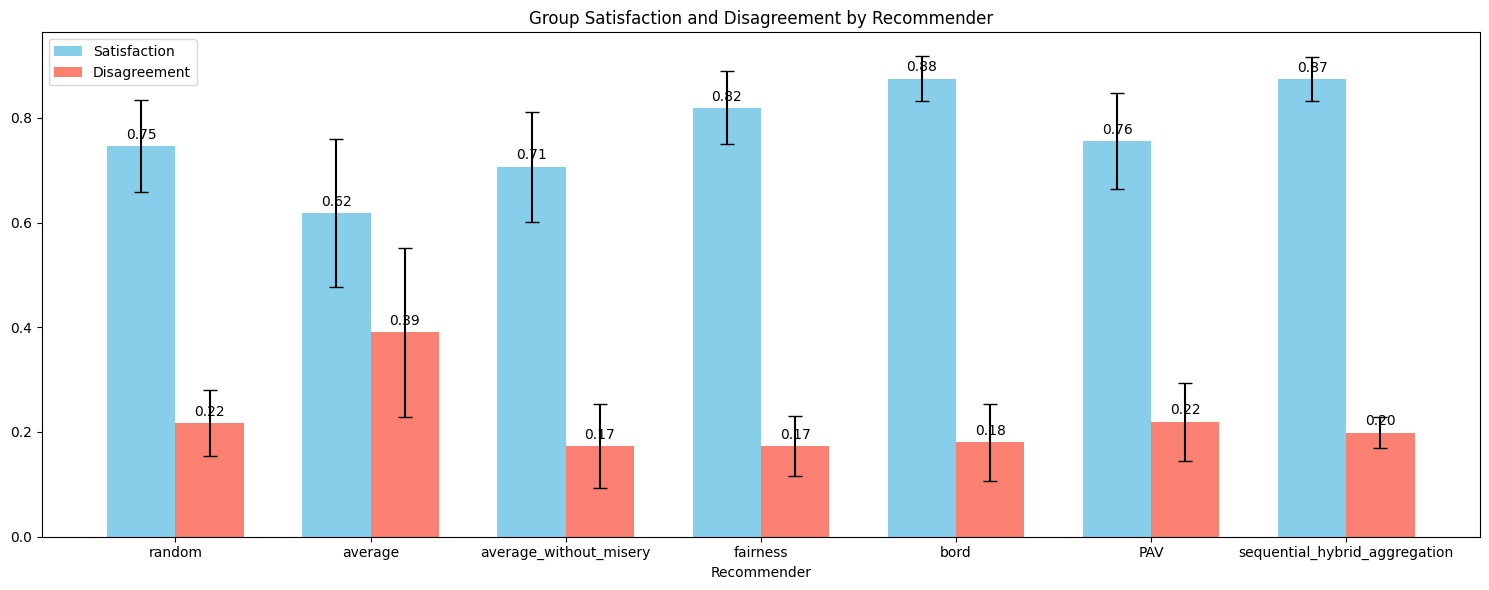

In [17]:
recommender_names = [recommender.name for recommender in recommenders]


x = np.arange(len(recommender_names))
width = 0.35
fig, ax = plt.subplots(figsize=(15, 6))


rects1 = ax.bar(x - width/2, satisfaction_means, width, label='Satisfaction', yerr=satisfaction_stds, capsize=5, color='skyblue')

rects2 = ax.bar(x + width/2, disagreement_means, width, label='Disagreement', yerr=disagreement_stds, capsize=5, color='salmon')

ax.set_xlabel('Recommender')
ax.set_title('Group Satisfaction and Disagreement by Recommender')
ax.set_xticks(x)
ax.set_xticklabels(recommender_names)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()
